# Evaluation of MODIS super resolution LST products. 
## The reference LST is obtained from concomitant ASTER LST images.
### This code evaluates the performances of different super resolution algorithms on the test dataset.

First, we import our libraries and set key parameters

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import skimage.metrics as met
import torch

import subprocess
import os
import ast
import zipfile
import pickle

from osgeo import gdal
import rasterio as rio
from rasterio.enums import Resampling
import pyproj
from shapely.geometry import box
from lpips import LPIPS
import data_mining_sharpener_modified as dms

from dataset import ModisDatasetB
from model import ModelB_2
import utils as us


pd.set_option("display.precision", 2)

Then, we define the different variables representing the working directory associated to the dataset and create the directories.

In [3]:
path_formatted_dataset = './test_data_formatted'
path_formatted_data = os.path.join(path_formatted_dataset, "data")
path_formatted_results = os.path.join(path_formatted_dataset, "results")
path_formatted_temporary = os.path.join(path_formatted_dataset, 'tmp')

os.makedirs(path_formatted_temporary, exist_ok = True)

# Reading the .csv dataset
df = pd.read_csv(os.path.join(path_formatted_dataset, "dataset.csv"))
df.drop(columns = "Unnamed: 0", inplace = True)
dict_files = df.T.to_dict(orient= 'list')

dict_results = {}

We load the data that will be georeferenced and that will be used in the super resolution approach

Then, we choose the super resolution algorithm: 
 - Bicubic interpolation
 - TsHARP
 - ATPRK 
 - AATPRK
 - DMS 
 - modelB (CNNs)

In [4]:
# Setting the super resolution approach, and loading the weights if using a pre-trained model
model_info = './models/modelB_1009/modelB_train_params.json' # CNN1
# model_info =  './models/modelB_2609/modelB_train_params.json' # CNN2

dataset_parameters, _, modelB_parameters, _, save_parameters, device = us.read_JsonB(model_info)
weights_path = os.path.join(save_parameters['save_path'], save_parameters['model_name'] + '_state_dict.pt')

stats = us.json_load(open('./data/statistics.json'))

prediction_device = 'cpu'

sr_type = "modelB" # Choose between: bicubic, TsHARP, ATPRK, AATPRK, DMS, modelB (CNN)

# Loading the model based on the type of inference.
if sr_type == "modelB":

    modelB = ModelB_2(in_channels = modelB_parameters['in_channels'], 
                            downchannels = modelB_parameters['downchannels'],
                            padding_mode = modelB_parameters['padding_mode'],
                            activation = modelB_parameters['activation'],
                            bilinear = modelB_parameters['bilinear'],
                            n_bridge_blocks = modelB_parameters['n_bridge_blocks']).to(prediction_device)
    
    if device != prediction_device:
        t = torch.load(weights_path, map_location=torch.device(prediction_device))
        modelB.load_state_dict(t)
    else: 
        modelB.load_state_dict(torch.load(weights_path))
    modelB.eval()

In [6]:
# Reading the data
lpips_loss = LPIPS(distance = 'mse', reduction = 'mean', mean = [0.0,0.0,0.0], std = [1.0,1.0,1.0]) # Initializing the LPIPS object
grad_lst_aster_tot = [] # In this list, we'll concatenate the gradients of Aster in order 
# to have estimation over the whole dataset.

idxs = list(dict_files.keys())
idx = idxs[0]    
print(idx)

# Loading the data from the csv
aster_tif = dict_files[idx][0]
modis_dict_path = dict_files[idx][1]

with open(modis_dict_path, 'rb') as f:
    modis_dict = pickle.load(f)

# Extracting the information from the dictionnary
lst = modis_dict['LST']
ndvi = modis_dict['NDVI']
center_lst = modis_dict["center_lst"] 
center = modis_dict["center_ndvi"]
f1_crs = modis_dict["CRS"] # Similar to MODIS one
transform_sr = modis_dict["transform affine SR"]
aster_srs = modis_dict["to CRS"] 
angle = modis_dict["aster_angle"]
geotransform_lst_patch = modis_dict['geo LST']
geotransform_ndvi_patch = modis_dict['geo NDVI']
proj_NDVI = modis_dict['proj NDVI']

# Defining the projections and the set parameters
modis_srs = '"+proj=sinu +R=6371007.181 +nadgrids=@null +wktext"'
interp = 'bilinear'

0


Increasing the spatial resolution with the chosen algorithm:

In [7]:
# Computing ndvi_down 
# Degrading the spatial resolution of the NDVI. Needed for TsHARP and ATPRK.
ndvi_down = us.downsampling_img(ndvi, (4, 4)) 
ndvi_down[ndvi_down>1] = 1
ndvi_down[ndvi_down<-1] = -1

lst_low = np.zeros((256,256))
for i in range(lst.shape[0]):
    for j in range(lst.shape[1]):
        lst_low[4*i:4*(i+1), 4*j:4*(j+1)] = lst[i,j]

# Works for bicubic directly since we give the bicubic as input of the model
lst_sr = cv2.resize(lst, dsize = (256, 256), interpolation=cv2.INTER_CUBIC)

if sr_type == 'modelB':
    lst_sr = torch.tensor((lst_sr - stats['mean_lst']) / stats['std_lst'], dtype = torch.float32)
    ndvi = torch.tensor((ndvi - stats['mean_ndvi']) / stats['std_ndvi'], dtype = torch.float32)
    lst_sr = lst_sr.unsqueeze(0).unsqueeze(0)
    ndvi = ndvi.unsqueeze(0).unsqueeze(0)
    
    x_lst_ndvi = torch.cat((lst_sr, ndvi), dim = 1)
    
    with torch.inference_mode():
        lst_sr = modelB(x_lst_ndvi) # for modelb_2
        
    lst_sr = lst_sr * stats['std_lst'] + stats['mean_lst']
    lst_sr = lst_sr.numpy()[0,0,:,:]
    
if sr_type == 'TsHARP':
    
    lst_sr = us.TsHARP(lst, ndvi_down[center_lst[0]-32:center_lst[0]+32, center_lst[1]-32:center_lst[1]+32], ndvi, 4, min_T = 273)

if sr_type == 'ATPRK':
    
    lst_sr = us.ATPRK(lst, ndvi_down[center_lst[0]-32:center_lst[0]+32, center_lst[1]-32:center_lst[1]+32], ndvi, scale = 4, scc = 926, block_size = 5, min_T = 273)
    
if sr_type == 'AATPRK':
    
    lst_sr = us.AATPRK(lst, ndvi_down[center_lst[0]-32:center_lst[0]+32, center_lst[1]-32:center_lst[1]+32], ndvi, scale = 4, scc = 926, block_size = 5, min_T = 273)

if sr_type == 'DMS': 
    lst_name_patch_tif = os.path.join(path_formatted_temporary, "{}_lst_patch.tif".format(idx))
    ndvi_name_patch_tif = os.path.join(path_formatted_temporary, "{}_ndvi_patch.tif".format(idx))
    
    us.save_GeoTiff(lst, lst_name_patch_tif, proj_NDVI, geotransform_lst_patch)
    us.save_GeoTiff(ndvi, ndvi_name_patch_tif, proj_NDVI, geotransform_ndvi_patch)
    
    # We're only using the decision tree
    commonOpts = {"highResFiles":               [ndvi_name_patch_tif],
                    "lowResFiles":                [lst_name_patch_tif],
                    "lowResQualityFiles":         [],
                    "lowResGoodQualityFlags":     [255],
                    "cvHomogeneityThreshold":     0,
                    "movingWindowSize":           0, #Only way to work with patches == removing local regs
                    "disaggregatingTemperature":  True}
    dtOpts =     {"perLeafLinearRegression":    True,
                    "linearRegressionExtrapolationRatio": 0.25}
    opts = commonOpts.copy()
    opts.update(dtOpts)
    disaggregator = dms.DecisionTreeSharpener(**opts)
    
    print("Training regressor...")
    disaggregator.trainSharpener()
    print("Sharpening...")
    downscaledFile, regs = disaggregator.applySharpener(ndvi_name_patch_tif, lst_name_patch_tif) 
    # regs was added to observe the decision tree.
    print("Residual analysis...")
    residualImage, correctedImage = disaggregator.residualAnalysis(downscaledFile, lst_name_patch_tif, doCorrection=True)
    lst_sr = correctedImage.GetRasterBand(1).ReadAsArray(0,0,256,256)

# Save here LST_low but without nn_upsampling in order to compare to ASTER. Do the same with MOD21A2
tmp = np.zeros((4800,4800)) # lst_sr
tmp1 = np.zeros((4800,4800)) # lst_low
tmp2 = np.zeros((4800,4800)) # ndvi
tmp1[center[0]-128:center[0]+128, center[1]-128:center[1]+128] = lst_low
tmp[center[0]-128:center[0]+128, center[1]-128:center[1]+128] = lst_sr
if sr_type == 'modelB':
    tmp2[center[0]-128:center[0]+128, center[1]-128:center[1]+128] = ndvi.numpy()[0,0,:,:] * stats['std_ndvi'] + stats['mean_ndvi']
else: 
    tmp2[center[0]-128:center[0]+128, center[1]-128:center[1]+128] = ndvi

path_lst_sr = os.path.join(path_formatted_temporary, "{}_lst_sr_modis.tif".format(idx))
path_lst_lr = os.path.join(path_formatted_temporary, "{}_lst_modis.tif".format(idx))
path_ndvi = os.path.join(path_formatted_temporary, "{}_ndvi_modis.tif".format(idx))

with rio.open(
    path_lst_sr,
    'w',
    driver='GTiff',
    height=tmp.shape[0],
    width=tmp.shape[1],
    count=1,
    dtype=tmp.dtype,
    crs=f1_crs,
    transform=transform_sr,
) as dst:
    dst.write(tmp, 1)
    
with rio.open(
    path_lst_lr,
    'w',
    driver='GTiff',
    height=tmp1.shape[0],
    width=tmp1.shape[1],
    count=1,
    dtype=tmp1.dtype,
    crs=f1_crs,
    transform=transform_sr,
) as dst:
    dst.write(tmp1, 1)

with rio.open(
    path_ndvi,
    'w',
    driver='GTiff',
    height=tmp2.shape[0],
    width=tmp2.shape[1],
    count=1,
    dtype=tmp2.dtype,
    crs=f1_crs,
    transform=transform_sr,
) as dst:
    dst.write(tmp2, 1)

Observing the downscaled data:

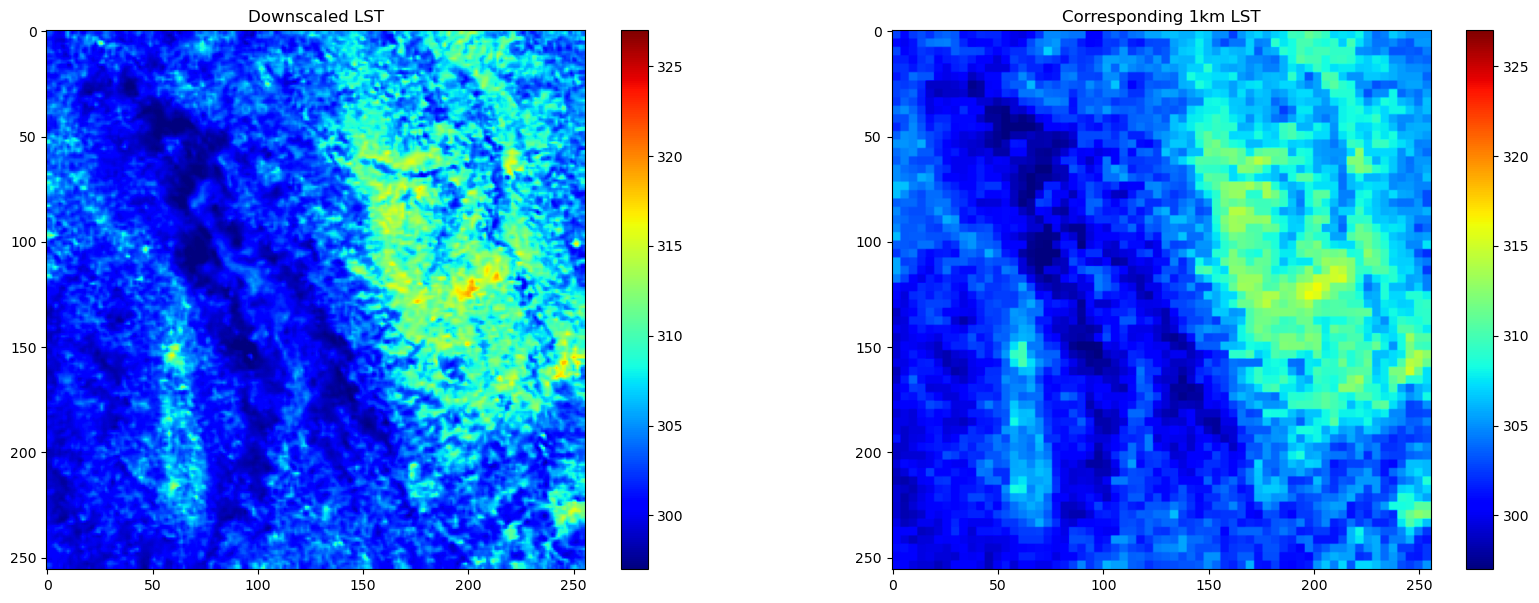

In [9]:
fig = plt.figure(1, figsize = (20,7))
ax1 = plt.subplot(1,2,1)
ig1 = plt.imshow(lst_sr, cmap = 'jet', vmin = 297, vmax = 327)
ax1.set_title("Downscaled LST")
plt.colorbar(ig1)
ax2 = plt.subplot(1,2,2)
ig2 = plt.imshow(lst_low, cmap = 'jet', vmin = 297, vmax = 327)
ax2.set_title('Corresponding 1km LST')
plt.colorbar(ig2)

Reprojecting all the MODIS data into the UTM projection:

In [10]:
 # Reprojecting the LST_SR, NDVI and the LST_LR into the UTM representation.
path_lst_sr_reproj = os.path.join(path_formatted_temporary, "{}_lst_sr_modis_reproj.tif".format(idx))
path_lst_lr_reproj = os.path.join(path_formatted_temporary, "{}_lst_modis_reproj.tif".format(idx))
path_ndvi_reproj = os.path.join(path_formatted_temporary, "{}_ndvi_modis_reproj.tif".format(idx))

command2_lst = "gdalwarp -s_srs {} -t_srs {} -r {} {} {}".format(modis_srs, aster_srs, interp, path_lst_sr, path_lst_sr_reproj)
command2_lst_lr = "gdalwarp -s_srs {} -t_srs {} -r {} {} {}".format(modis_srs, aster_srs, interp, path_lst_lr, path_lst_lr_reproj)
command2_ndvi = "gdalwarp -s_srs {} -t_srs {} -r {} {} {}".format(modis_srs, aster_srs, interp, path_ndvi, path_ndvi_reproj)
subprocess.run(command2_lst, shell = True)
subprocess.run(command2_lst_lr, shell = True)
subprocess.run(command2_ndvi, shell = True)

ERROR 1: PROJ: Cannot open https://cdn.proj.org/@null: HTTP error 404: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Key>@null</Key><RequestId>1TTSP8Q2ANFKC9HT</RequestId><HostId>4jzH3kdlXMWUE29xG5Oag2Ky8dnMKPQLuwaxvdw8qbPF+SEEugyu3T8BDjNTalvQGg4/tqHhvCY=</HostId></Error>


Creating output file that is 5179P x 5323L.
Processing ./test_data_formatted/tmp/0_lst_sr_modis.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5179P x 5323L.
Processing ./test_data_formatted/tmp/0_lst_modis.tif [1/1] : 0.

ERROR 1: PROJ: Cannot open https://cdn.proj.org/@null: HTTP error 404: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Key>@null</Key><RequestId>1TTSP8Q2ANFKC9HT</RequestId><HostId>4jzH3kdlXMWUE29xG5Oag2Ky8dnMKPQLuwaxvdw8qbPF+SEEugyu3T8BDjNTalvQGg4/tqHhvCY=</HostId></Error>


..10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: PROJ: Cannot open https://cdn.proj.org/@null: HTTP error 404: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Key>@null</Key><RequestId>1TTSP8Q2ANFKC9HT</RequestId><HostId>4jzH3kdlXMWUE29xG5Oag2Ky8dnMKPQLuwaxvdw8qbPF+SEEugyu3T8BDjNTalvQGg4/tqHhvCY=</HostId></Error>


Creating output file that is 5179P x 5323L.
Processing ./test_data_formatted/tmp/0_ndvi_modis.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


CompletedProcess(args='gdalwarp -s_srs "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext" -t_srs EPSG:32631 -r bilinear ./test_data_formatted/tmp/0_ndvi_modis.tif ./test_data_formatted/tmp/0_ndvi_modis_reproj.tif', returncode=0)

Finally, the common area is computed between the two reprojected images.


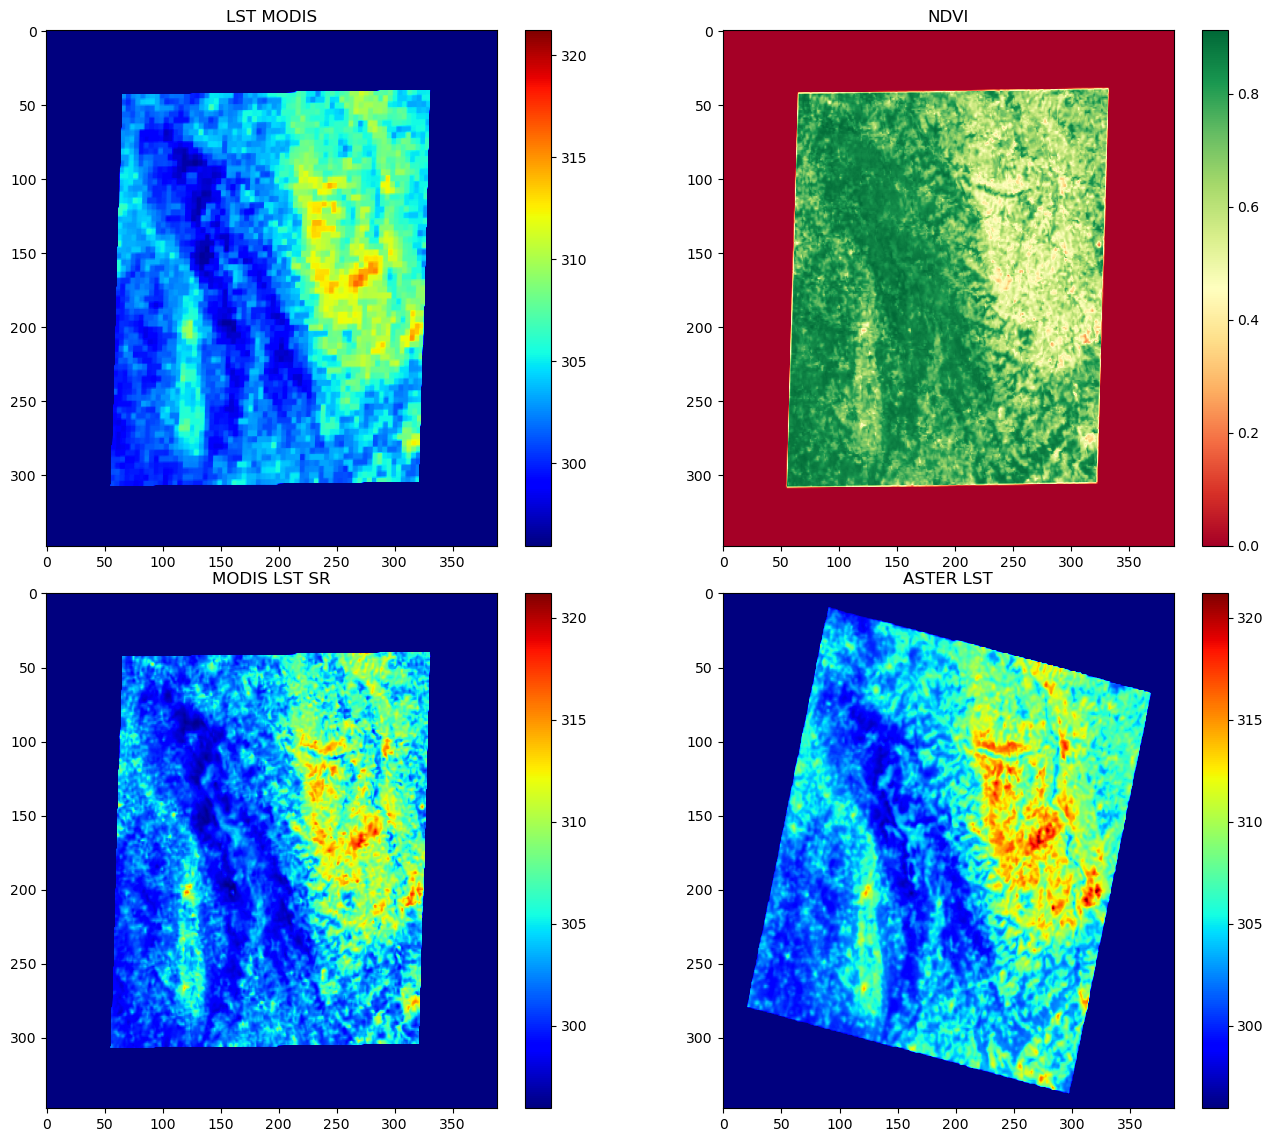

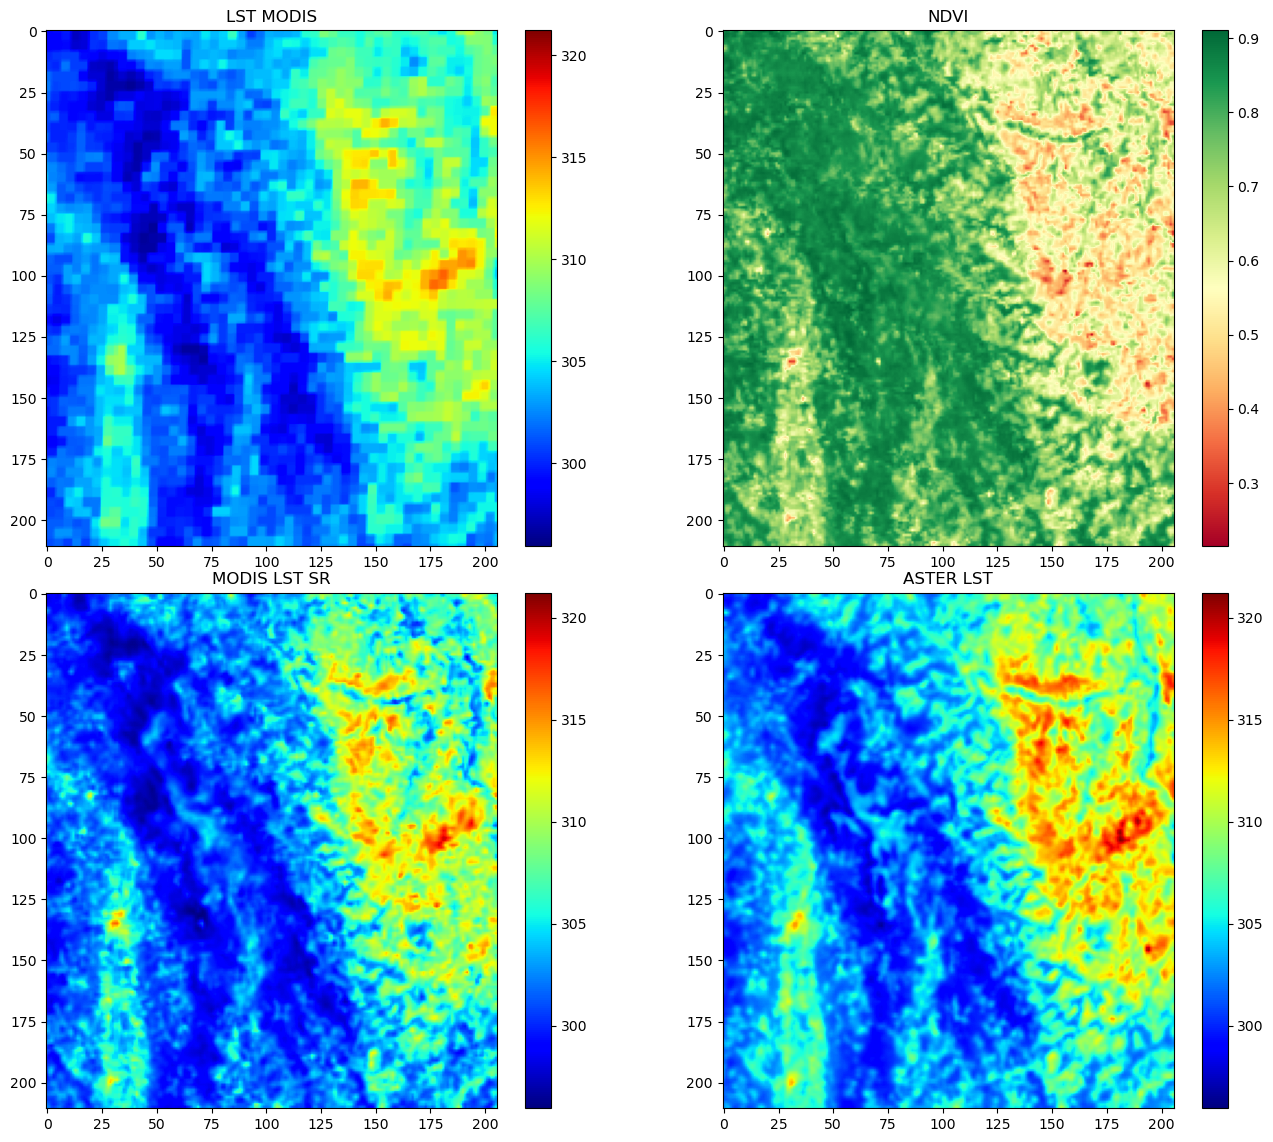

In [12]:
###### FINALLY, WE FIND THE COMMON AREA BETWEEN MODIS and ASTER LSTs.
ras_1 = aster_tif
ras_2 = path_lst_sr_reproj # MOD21A1D super resolution
ras_3 = path_lst_lr_reproj # MOD21A1D original
ras_4 = path_ndvi_reproj # Corresponding NDVI

with rio.open(ras_1) as ras1, rio.open(ras_2) as ras2, rio.open(ras_3) as ras3, rio.open(ras_4) as ras4: # Without the RGB
    transform_int = ras1.transform * ras1.transform.shear(angle, -angle)
               
    x_scale = transform_int.a / ras2.transform.a
    y_scale = transform_int.e / ras2.transform.e
    
    transform = ras1.transform * ras1.transform.scale(
        (ras1.width / ras1.shape[-1]),
        (ras1.height / ras1.shape[-2])
    )
    
    ### For Aster
    ext1 = box(*ras1.bounds)
    ext2 = box(*ras2.bounds)
    intersection = ext1.intersection(ext2)
    win1 = rio.windows.from_bounds(*intersection.bounds, transform)
    win2 = rio.windows.from_bounds(*intersection.bounds, ras2.transform)
    
    # The window should be the same for all the files coming from Modis
    overlap_1 = ras1.read(window=win1,
    out_shape=(
        ras1.count,
        int(win1.height * y_scale),
        int(win1.width * x_scale)
    ),
    resampling=Resampling.bilinear)
    overlap_2 = ras2.read(window = win2)
    overlap_3 = ras3.read(window = win2)
    overlap_4 = ras4.read(window = win2)
    
# Applying the scale factor
overlap_1 *= 0.1

p1_aster,p2_aster = us.find_corners(overlap_1[0], us.condition_lst_aster)
p1_modis,p2_modis = us.find_corners(overlap_2[0], us.condition_lst_modis)

p1 = (max(p1_modis[0], p1_aster[0]) + 1, min(p1_modis[1], p1_aster[1]) - 1 )
p2 = (max(p2_modis[0], p2_aster[0]) + 1, min(p2_modis[1], p2_aster[1]) - 1 )

overlap_11 = overlap_1.copy()[0,p2[0]-1:p2[1]-1,p1[0]-1:p1[1]-1] 
overlap_22 = overlap_2.copy()[0,p2[0]-1:p2[1]-1,p1[0]-1:p1[1]-1]
overlap_33 = overlap_3.copy()[0,p2[0]-1:p2[1]-1,p1[0]-1:p1[1]-1]
overlap_44 = overlap_4.copy()[0,p2[0]-1:p2[1]-1,p1[0]-1:p1[1]-1]

maxi = np.max([overlap_11,overlap_22])
mini = np.min([overlap_11,overlap_22])

fig = plt.figure(1, figsize = (16, 14))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.5)

ax1 = fig.add_subplot(gs[:2, :2])
ig1 = ax1.imshow(overlap_3[0,:,:], cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi)
plt.colorbar(ig1)
ax1.title.set_text("LST MODIS")

ax2 = fig.add_subplot(gs[:2, 2:])
ig2 = ax2.imshow(overlap_4[0,:,:], cmap = 'RdYlGn', aspect = 'auto')
plt.colorbar(ig2)
ax2.title.set_text('NDVI')

ax3 = fig.add_subplot(gs[2:, :2])
ig3 = ax3.imshow(overlap_2[0,:,:], cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi)
plt.colorbar(ig3)
ax3.title.set_text("MODIS LST SR")

ax4 = fig.add_subplot(gs[2:, 2:])
ig4 = ax4.imshow(overlap_1[0,:,:], cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi) 
plt.colorbar(ig4)
ax4.title.set_text('ASTER LST')


# Plotting the final cropped results
fig = plt.figure(2, figsize = (16, 14))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.5)

ax1 = fig.add_subplot(gs[:2, :2])
ig1 = ax1.imshow(overlap_33, cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi)
plt.colorbar(ig1)
ax1.title.set_text("LST MODIS")

ax2 = fig.add_subplot(gs[:2, 2:])
ig2 = ax2.imshow(overlap_44, cmap = 'RdYlGn', aspect = 'auto')
plt.colorbar(ig2)
ax2.title.set_text('NDVI')

ax3 = fig.add_subplot(gs[2:, :2])
ig3 = ax3.imshow(overlap_22, cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi)
plt.colorbar(ig3)
ax3.title.set_text("MODIS LST SR")

ax4 = fig.add_subplot(gs[2:, 2:])
ig4 = ax4.imshow(overlap_11, cmap = 'jet', aspect = 'auto', vmin = mini, vmax = maxi) 
plt.colorbar(ig4)
ax4.title.set_text('ASTER LST')


# Finally, we save the prediction and the LST aster for 
dict_output = {'LST:': overlap_33,
                'NDVI': overlap_44,
                'LST_ASTER': overlap_11,
                'LST_SR': overlap_22}

Displaying the metrics on this single example

In [13]:
# Computing the similarity metrics:  (Note: They fourier space similarity metrics are not computed here)

# Computing the rmse for low and high ASTER grads
aster_lst_1000m = us.get_output_ftm(torch.tensor(overlap_11).unsqueeze(0).unsqueeze(0)).numpy()[0,0,:,:]
grad_aster = np.abs(overlap_11 - aster_lst_1000m)

grad_lst_aster_tot += list(grad_aster.flatten())

sqe_modis_sr_aster = np.power(overlap_11 - overlap_22, 2)

grad_aster_low = np.percentile(grad_aster.flatten(), 25)
grad_aster_high = np.percentile(grad_aster.flatten(), 75)

error_low_grad = sqe_modis_sr_aster.copy()
error_low_grad[grad_aster >= grad_aster_low] = 0
vals_without_zeros = list(filter((0.0).__ne__, list(error_low_grad.flatten())))
rmse_low_grad = np.sqrt(np.mean(vals_without_zeros))

error_mean_grad = sqe_modis_sr_aster.copy()
error_mean_grad[grad_aster < grad_aster_low] = 0
error_mean_grad[grad_aster > grad_aster_high] = 0
vals_without_zeros = list(filter((0.0).__ne__, list(error_mean_grad.flatten())))
rmse_mean_grad = np.sqrt(np.mean(vals_without_zeros))

error_high_grad = sqe_modis_sr_aster.copy()
error_high_grad[grad_aster < grad_aster_high] = 0
vals_without_zeros = list(filter((0.0).__ne__, list(error_high_grad.flatten())))
rmse_high_grad = np.sqrt(np.mean(vals_without_zeros))
# The 0.0 is really important. If only using 0, the filter
# doesn't work

sobels = [ [[1,2,1],[0,0,0],[-1,-2,-1]],
            [[1,0,-1],[2,0,-2],[1,0,-1]],
            [[2,1,0],[1,0,-1],[0,-1,-2]],
            [[0,1,2],[-1,0,1],[-2,-1,0]]]

grads_modis = []
grads_aster = []
for sobel in sobels:
    grads_modis.append(sp.signal.convolve2d(overlap_22, sobel, mode = 'valid'))
    grads_aster.append(sp.signal.convolve2d(overlap_11, sobel, mode = 'valid'))

mag_modis = np.sqrt(np.power(grads_modis[0],2) +np.power(grads_modis[1],2) +np.power(grads_modis[2],2) + np.power(grads_modis[3],2))
mag_aster = np.sqrt(np.power(grads_aster[0],2) +np.power(grads_aster[1],2) +np.power(grads_aster[2],2) + np.power(grads_aster[3],2))

# Computing LPIPS
# Making the data in right format
t1 = torch.tensor((overlap_11 - mini)/(maxi - mini), dtype = torch.float).repeat(1,3,1,1)
t2 = torch.tensor((overlap_22 - mini)/(maxi - mini), dtype = torch.float).repeat(1,3,1,1)

val_lpips = lpips_loss(t1, t2).numpy()

dict_results[idx] = [
met.peak_signal_noise_ratio(overlap_11, overlap_22, data_range=maxi - mini),
met.structural_similarity(overlap_11, overlap_22, data_range=maxi - mini),
np.sqrt(np.mean(sqe_modis_sr_aster)),
rmse_low_grad,
rmse_mean_grad,
rmse_high_grad,
us.gssim(overlap_11, overlap_22, data_range = maxi-mini),
val_lpips,
np.sqrt(np.mean((np.power(mag_modis - mag_aster,2))))
]

labels = ['PSNR', 'SSIM', 'RMSE', 'RMSE<25%', 'RMSE>25%<75%', 'RMSE>75%', 'GSSIM', 'LPIPS', 'RMSE_gradients']

to_print = ""
for i, val in enumerate(dict_results[idx]):
    to_print += "{}: {:.2f}  ".format(labels[i], val)

print(to_print)
# The metrics in the fourier space are not computed here as they require the computation of the bicubic (which is done but I don't want this example to add also this.)


PSNR: 22.25  SSIM: 0.69  RMSE: 1.95  RMSE<25%: 1.75  RMSE>25%<75%: 1.82  RMSE>75%: 2.35  GSSIM: 0.34  LPIPS: 0.24  RMSE_gradients: 6.96  


In [14]:
# Removing the intermediary generated files
files_to_remove = [os.path.join(path_formatted_temporary, f) for f in os.listdir(path_formatted_temporary) if os.path.isfile(os.path.join(path_formatted_temporary, f))] 

for file in files_to_remove:
    os.remove(file)